**Data Mining Assingment 1**

In [312]:
#Imports
!pip install dmba
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
import statsmodels.formula.api as sm
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

**Question 1**


a.

In [313]:
print(train.shape)
#1,168 rows is 80% of the train data set
sample = train.sample(n=1168, random_state=2501)

(1460, 81)


**b.** There are 1,168 rows and 81 columns in the sample. Each row represents a house in Ames, Iowa and the columns describe the characteristics of each property.

**c.**

In [314]:
#Finding continuous and categorical variables
integer = []
categorical = []

#First step to filter columns
for col in sample.columns:
  if sample[col].dtype == 'int' or sample[col].dtype == 'float':
    integer.append(col)
  else:
    categorical.append(col)

#Remove categorical variables from integer list
integer.remove('MSSubClass')
integer.remove('OverallQual')
integer.remove('OverallCond')
integer.remove('YearBuilt')
integer.remove('YearRemodAdd')
integer.remove('MoSold')
integer.remove('YrSold')

#Add removed columns to categorical list
categorical.append('MSSubClass')
categorical.append('OverallQual')
categorical.append('OverallCond')
categorical.append('YearBuilt')
categorical.append('YearRemodAdd')
categorical.append('MoSold')
categorical.append('YrSold')

print('Continuous:', integer)
print('Categorical:', categorical)
print(train.describe())

Continuous: ['Id', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice']
Categorical: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature

**Categorical:** These variables are used to describe or rank different aspects of a property. These will need to be changed to dummy variables in order to work in a regression model.

**Continuous:** These are integer based columns that also describe aspects of any given property. These do not need to be changed in order to work in the model

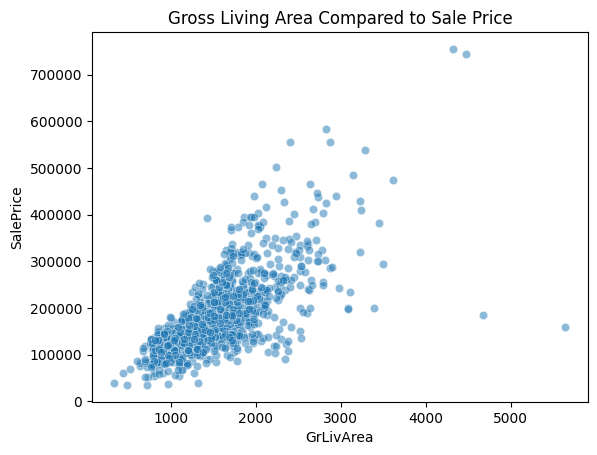

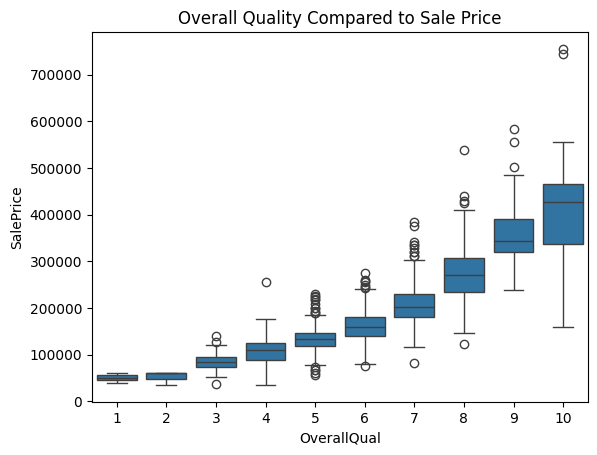

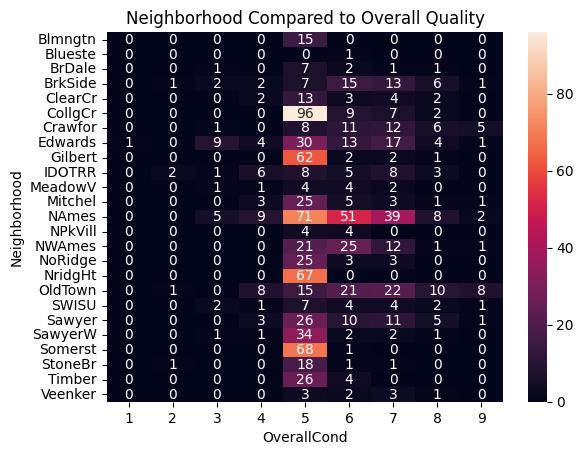

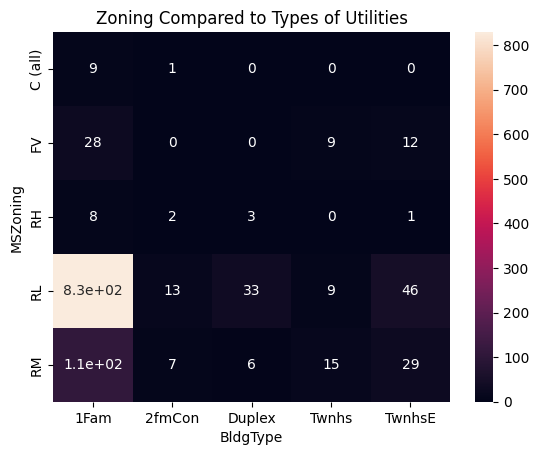

In [315]:
#Scatter Plots
sns.scatterplot(data=sample, x='GrLivArea', y='SalePrice', alpha=0.5)
plt.title('Gross Living Area Compared to Sale Price')
plt.show()

sns.boxplot(data=sample, x='OverallQual', y='SalePrice')
plt.title('Overall Quality Compared to Sale Price')
plt.show()

#Contingency Tables
contingency1 = pd.crosstab(sample['Neighborhood'], sample['OverallCond'])
sns.heatmap(contingency1, annot=True)
plt.title('Neighborhood Compared to Overall Quality')
plt.show()

contingency2 = pd.crosstab(sample['MSZoning'], sample['BldgType'])
sns.heatmap(contingency2, annot=True)
plt.title('Zoning Compared to Types of Utilities')
plt.show()

**Scatter Plots:** In the first graph comparing gross living area square footage to the sale price, it is clear there is a positive relationship between the two variables which makes sense. The larger the property is, the more it will sell for (in most cases). The other graph is a box whisker plot of the overall quality of the property compared to the sale price. This also has a noticable positive relationship which indicates as the quality rank rises, the sales price does as well.

**Contingency Tables:** The first table compares each neighborhood's overall quality of each property. It seems that North Ames has the best quality on average for their properties (also has the most properties) with Edwards having a few properties with a quality grade of only 3. The second table shows the types of buildings in each way a property is zoned. Residential Medium and Residential Large has the most 1 family properties which is no surprise and contain the majority of the properties in Ames.

**e.**

In [316]:
corr_matrix = sample[integer].corr()
#Using a threshold of 0.8 to find highly correlated predictors
high_corr = np.where(abs(corr_matrix) > 0.8)
#Find the variables and filter out the self correlated pairs
high_corr = [(corr_matrix.index[x], corr_matrix.columns[y]) for x, y in zip(*high_corr) if x != y]
print(high_corr)

[('TotalBsmtSF', '1stFlrSF'), ('1stFlrSF', 'TotalBsmtSF'), ('GrLivArea', 'TotRmsAbvGrd'), ('TotRmsAbvGrd', 'GrLivArea'), ('GarageCars', 'GarageArea'), ('GarageArea', 'GarageCars')]


The printed values above are correlated above a 0.8 threshold, indicating they are highly correlated to each other. The 3 pairs are basement square footage and first floor square footage, gross living area and total rooms above ground, and lastly the number of cars that can fit in a garage and the garage's area. I wouldn't aggregate any of these variables since they might all be important in predicting the sale price of a property. Basement square footage adds to the total square footage even though it is below the first floor, the amount of rooms above ground will add more value to a property, and the amount of cars that can fit in a garage is important as well.

**f.**

In [317]:
corr_saleprice = corr_matrix['SalePrice']
print(corr_saleprice)

Id              -0.043493
LotFrontage      0.347257
LotArea          0.270541
MasVnrArea       0.462413
BsmtFinSF1       0.386000
BsmtFinSF2      -0.000135
BsmtUnfSF        0.218955
TotalBsmtSF      0.607723
1stFlrSF         0.602648
2ndFlrSF         0.314262
LowQualFinSF    -0.013596
GrLivArea        0.702258
BsmtFullBath     0.239823
BsmtHalfBath    -0.023556
FullBath         0.567591
HalfBath         0.274414
BedroomAbvGr     0.169921
KitchenAbvGr    -0.137038
TotRmsAbvGrd     0.536763
Fireplaces       0.470063
GarageYrBlt      0.493637
GarageCars       0.641528
GarageArea       0.635806
WoodDeckSF       0.341924
OpenPorchSF      0.305949
EnclosedPorch   -0.112569
3SsnPorch        0.034516
ScreenPorch      0.115084
PoolArea         0.111111
MiscVal         -0.026515
SalePrice        1.000000
Name: SalePrice, dtype: float64


Variables like 1st floor square footage, total basement square footage, garage area, and full bath are strongly correlated with sales price with values ranging between 0.5 and 0.6, but the largest correlation is gross living area with a value of 0.7086. This makes sense intuitively since the larger the property is, the more value it will have.

**g.**

In [318]:
missing = sample.isnull().sum()
#To print the whole output
pd.set_option('display.max_rows', None)
print(missing)

#Mannually change null values in specific columns
sample['LotFrontage'] = sample['LotFrontage'].fillna(sample['LotFrontage'].mean())
sample['Alley'] = sample['Alley'].fillna('NA')
sample['MasVnrType'] = sample['MasVnrType'].fillna('None')
sample['MasVnrArea'] = sample['MasVnrArea'].fillna(0)
sample['BsmtQual'] = sample['BsmtQual'].fillna('NA')
sample['BsmtCond'] = sample['BsmtCond'].fillna('NA')
sample['BsmtExposure'] = sample['BsmtExposure'].fillna('NA')
sample['BsmtFinType1'] = sample['BsmtFinType1'].fillna('NA')
sample['BsmtFinType2'] = sample['BsmtFinType2'].fillna('NA')
sample['Electrical'] = sample['Electrical'].fillna('SBrkr')
sample['FireplaceQu'] = sample['FireplaceQu'].fillna('NA')
sample['GarageType'] = sample['GarageType'].fillna('NA')
sample['GarageYrBlt'] = sample['GarageYrBlt'].fillna(sample['GarageYrBlt'].median())
sample['GarageFinish'] = sample['GarageFinish'].fillna('NA')
sample['GarageQual'] = sample['GarageQual'].fillna('NA')
sample['GarageCond'] = sample['GarageCond'].fillna('NA')
sample['PoolQC'] = sample['PoolQC'].fillna('NA')
sample['Fence'] = sample['Fence'].fillna('NA')
sample['MiscFeature'] = sample['MiscFeature'].fillna('NA')

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       203
LotArea             0
Street              0
Alley            1101
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType        686
MasVnrArea          6
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           30
BsmtCond           30
BsmtExposure       31
BsmtFinType1       30
BsmtFinSF1          0
BsmtFinType2       31
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

**h.** Since I already handled missing values, I would then create dummy variables before creating a linear regression for the categorical variables.

**Question 2**

a.



In [319]:
#Create validation set by dropping rows in the sample
validation = train.drop(sample.index)

#Clean validation set
validation['LotFrontage'] = validation['LotFrontage'].fillna(sample['LotFrontage'].mean())
validation['Alley'] = validation['Alley'].fillna('NA')
validation['MasVnrType'] = validation['MasVnrType'].fillna('None')
validation['MasVnrArea'] = validation['MasVnrArea'].fillna(0)
validation['BsmtQual'] = validation['BsmtQual'].fillna('NA')
validation['BsmtCond'] = validation['BsmtCond'].fillna('NA')
validation['BsmtExposure'] = validation['BsmtExposure'].fillna('NA')
validation['BsmtFinType1'] = validation['BsmtFinType1'].fillna('NA')
validation['BsmtFinType2'] = validation['BsmtFinType2'].fillna('NA')
validation['Electrical'] = validation['Electrical'].fillna('SBrkr')
validation['FireplaceQu'] = validation['FireplaceQu'].fillna('NA')
validation['GarageType'] = validation['GarageType'].fillna('NA')
validation['GarageYrBlt'] = validation['GarageYrBlt'].fillna(validation['GarageYrBlt'].median())
validation['GarageFinish'] = validation['GarageFinish'].fillna('NA')
validation['GarageQual'] = validation['GarageQual'].fillna('NA')
validation['GarageCond'] = validation['GarageCond'].fillna('NA')
validation['PoolQC'] = validation['PoolQC'].fillna('NA')
validation['Fence'] = validation['Fence'].fillna('NA')
validation['MiscFeature'] = validation['MiscFeature'].fillna('NA')

#Variable summary
validation.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,...,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000
mean,739.684932,60.342466,67.979594,10512.801370,6.051370,5.578767,1971.113014,1984.698630,90.318493,451.294521,...,92.568493,44.863014,24.660959,4.736301,15.256849,2.219178,42.123288,6.332192,2007.750000,176867.465753
std,429.302091,46.335314,19.244732,10505.365403,1.238319,1.040731,30.147819,20.196073,174.245427,442.674093,...,125.829886,59.004878,63.417166,38.202152,55.524854,37.921332,495.934965,2.683011,1.345413,73727.065695
min,1.000000,20.000000,21.000000,1477.000000,3.000000,3.000000,1880.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,62383.000000
25%,403.750000,20.000000,60.000000,7299.000000,5.000000,5.000000,1954.000000,1967.750000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,130000.000000
50%,700.500000,50.000000,70.715026,9273.500000,6.000000,5.000000,1972.000000,1992.000000,0.000000,409.000000,...,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000
75%,1134.750000,70.000000,78.000000,11500.000000,7.000000,6.000000,2000.000000,2003.000000,120.000000,735.500000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,203100.000000
max,1460.000000,190.000000,134.000000,159000.000000,10.000000,9.000000,2009.000000,2010.000000,1378.000000,2188.000000,...,736.000000,304.000000,386.000000,508.000000,396.000000,648.000000,8300.000000,12.000000,2010.000000,625000.000000


In [320]:
sample.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,...,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000
mean,728.203767,56.035959,70.715026,10517.834760,6.111301,5.574486,1971.306507,1984.907534,106.316781,441.726027,...,94.663527,47.109589,21.277397,3.077911,15.011986,2.893836,43.830479,6.319349,2007.832192,181934.628425
std,419.819982,41.206593,22.641928,9850.566018,1.417098,1.130522,30.229432,20.764522,182.248996,459.558400,...,125.266273,67.963963,60.540044,26.647753,55.839007,40.736249,496.381817,2.709892,1.323801,80806.402970
min,3.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,357.750000,20.000000,60.000000,7589.500000,5.000000,5.000000,1954.000000,1966.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129900.000000
50%,735.500000,50.000000,70.715026,9525.000000,6.000000,5.000000,1973.000000,1994.000000,0.000000,377.500000,...,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163995.000000
75%,1087.500000,70.000000,79.000000,11616.000000,7.000000,6.000000,2001.000000,2004.000000,170.000000,702.500000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,215050.000000
max,1459.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,407.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


One concern regarding the partition is the amount of data in the validation set. 292 rows may not be enough data to actually validate the model.

**b.**

In [321]:
#Create dummies
sample = pd.get_dummies(sample, drop_first=True)
validation = pd.get_dummies(validation, drop_first=True)
validation = validation.reindex(columns=sample.columns, fill_value=0)

#Arbitrarily add predictors for first model
predictors = ['OverallQual', 'OverallCond',
              'GrLivArea', 'LotArea', 'GarageArea']
outcome = 'SalePrice'

model = LinearRegression()
model.fit(sample[predictors], sample[outcome])

# print coefficients
print('intercept ', model.intercept_)
print(pd.DataFrame({'Predictor': predictors, 'coefficient': model.coef_}))

# print performance measures
pred_y = model.predict(sample[predictors])
regressionSummary(sample[outcome], pred_y)

#Training scores
print('adjusted r2 : ', adjusted_r2_score(sample[outcome], pred_y, model))
print('AIC : ', AIC_score(sample[outcome], pred_y, model))
print('BIC : ', BIC_score(sample[outcome], pred_y, model))

#Validation scores
v_pred_y = model.predict(validation[predictors])
regressionSummary(validation[outcome], v_pred_y)
print('adjusted r2 : ', adjusted_r2_score(validation[outcome], v_pred_y, model))
print('AIC : ', AIC_score(validation[outcome], v_pred_y, model))
print('BIC : ', BIC_score(validation[outcome], v_pred_y, model))

#Print first 10 predictors for test set (need to clean first)
test['LotFrontage'] = test['LotFrontage'].fillna(sample['LotFrontage'].mean())
test['Alley'] = test['Alley'].fillna('NA')
test['MasVnrType'] = test['MasVnrType'].fillna('None')
test['MasVnrArea'] = test['MasVnrArea'].fillna(0)
test['BsmtQual'] = test['BsmtQual'].fillna('NA')
test['BsmtCond'] = test['BsmtCond'].fillna('NA')
test['BsmtExposure'] = test['BsmtExposure'].fillna('NA')
test['BsmtFinType1'] = test['BsmtFinType1'].fillna('NA')
test['BsmtFinType2'] = test['BsmtFinType2'].fillna('NA')
test['Electrical'] = test['Electrical'].fillna('SBrkr')
test['FireplaceQu'] = test['FireplaceQu'].fillna('NA')
test['GarageType'] = test['GarageType'].fillna('NA')
test['GarageYrBlt'] = test['GarageYrBlt'].fillna(test['GarageYrBlt'].median())
test['GarageFinish'] = test['GarageFinish'].fillna('NA')
test['GarageQual'] = test['GarageQual'].fillna('NA')
test['GarageCond'] = test['GarageCond'].fillna('NA')
test['PoolQC'] = test['PoolQC'].fillna('NA')
test['Fence'] = test['Fence'].fillna('NA')
test['MiscFeature'] = test['MiscFeature'].fillna('NA')
test['MSZoning'] = test['MSZoning'].fillna('RM')
test['Utilities'] = test['Utilities'].fillna('AllPub')
test['Exterior1st'] = test['Exterior1st'].fillna('VinylSd')
test['Exterior2nd'] = test['Exterior2nd'].fillna('VinylSd')
test['BsmtFinSF1'] = test['BsmtFinSF1'].fillna(0)
test['BsmtFinSF2'] = test['BsmtFinSF2'].fillna(0)
test['BsmtUnfSF'] = test['BsmtUnfSF'].fillna(0)
test['TotalBsmtSF'] = test['TotalBsmtSF'].fillna(0)
test['BsmtFullBath'] = test['BsmtFullBath'].fillna(0)
test['BsmtHalfBath'] = test['BsmtHalfBath'].fillna(0)
test['KitchenQual'] = test['KitchenQual'].fillna('TA')
test['Functional'] = test['Functional'].fillna('Typ')
test['GarageYrBlt'] = test['GarageYrBlt'].fillna(test['GarageYrBlt'].median())
test['GarageCars'] = test['GarageCars'].fillna(0)
test['GarageArea'] = test['GarageArea'].fillna(0)
test['SaleType'] = test['SaleType'].fillna('Oth')

t_pred_y = model.predict(test[predictors])
print('First 10 Predictions:', t_pred_y[:10])

intercept  -112512.71087855301
     Predictor   coefficient
0  OverallQual  28650.016050
1  OverallCond   1783.373342
2    GrLivArea     43.369032
3      LotArea      0.770298
4   GarageArea     74.512739

Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 40424.5653
            Mean Absolute Error (MAE) : 26425.1727
          Mean Percentage Error (MPE) : -2.5183
Mean Absolute Percentage Error (MAPE) : 16.3099
adjusted r2 :  0.7484433037534628
AIC :  28107.043102324533
BIC :  28142.48443946825

Regression statistics

                      Mean Error (ME) : -1614.0884
       Root Mean Squared Error (RMSE) : 37296.9553
            Mean Absolute Error (MAE) : 24839.5839
          Mean Percentage Error (MPE) : -3.3567
Mean Absolute Percentage Error (MAPE) : 14.9720
adjusted r2 :  0.7387178864764584
AIC :  6990.2336174613165
BIC :  7015.970894077194
First 10 Predictions: [143642.96676367 161962.88755969 156870.75318282 182358.57545

**Regression Equation:** -109187.53 + 28555.25(OverallQual) + 1780(OverallCond) + 46.373(GrLivArea) + 0.76(LotArea) + 74.3(GarageArea)

There are many problems with this model as the predictors were chosen arbitrarily not based on any stepwise method. The R^2 for the training set explains 74.8% of the variance (all else being constant and on average) in the data and that decreases slightly to 73.8% for the validation. One interesting RMSE actually decreases in the validation set by $3,000, which may mean the model translates well to the test data set.

**c.**

In [323]:
#Create training and validation X's and Y's
train_X = sample.drop('SalePrice', axis = 1)
train_y = sample['SalePrice']
valid_y = validation['SalePrice']
valid_X = validation.drop('SalePrice', axis = 1)

#Backward Elimination
def train_model_b(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model_b(model, variables):
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model_b, best_variables_b = backward_elimination(train_X.columns, train_model_b, score_model_b, verbose=True)

print(best_variables_b)
regressionSummary(valid_y, best_model_b.predict(valid_X[best_variables_b]))

#Forward Selection
def train_model_f(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model_f(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model_f, best_variables_f = forward_selection(train_X.columns, train_model_f, score_model_f, verbose=True)
print(best_variables_f)
regressionSummary(valid_y, best_model_f.predict(valid_X[best_variables_f]))

#Both (Stepwise)
#Using forward selection's train and score model functions for stepwise
best_model, best_variables = stepwise_selection(train_X.columns, train_model_f, score_model_f, verbose=True)
print(best_variables)
regressionSummary(valid_y, best_model.predict(valid_X[best_variables]))

Variables: Id, MSSubClass, LotFrontage, LotArea, OverallQual, OverallCond, YearBuilt, YearRemodAdd, MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, GarageYrBlt, GarageCars, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal, MoSold, YrSold, MSZoning_FV, MSZoning_RH, MSZoning_RL, MSZoning_RM, Street_Pave, Alley_NA, Alley_Pave, LotShape_IR2, LotShape_IR3, LotShape_Reg, LandContour_HLS, LandContour_Low, LandContour_Lvl, LotConfig_CulDSac, LotConfig_FR2, LotConfig_FR3, LotConfig_Inside, LandSlope_Mod, LandSlope_Sev, Neighborhood_Blueste, Neighborhood_BrDale, Neighborhood_BrkSide, Neighborhood_ClearCr, Neighborhood_CollgCr, Neighborhood_Crawfor, Neighborhood_Edwards, Neighborhood_Gilbert, Neighborhood_IDOTRR, Neighborhood_MeadowV, Neighborhood_Mitchel, Neighborhood_NAmes, Neighborhood_NPkVill

The RMSE in these models are extremely high, but the forward selection was the lowest with around 500,000. These are extremely complex models with a lot of predictors each, so they have a lot of variance and would not be great at predicting data that was not seen before. The model I create with only 5 predictors did much better since it was a very simple model, but it might also introduce bias because of its simplicity. More processing and perhaps a different technique would make a much better model.